# Regression for Bioprinting

Here we will train some simple regression models on the dataset to see if we can estimate similarity index (printing performance) based pressure, temperature, and model complexity.

### Importing modules

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from copy import deepcopy

### Defining Global Constants

In [15]:
DATA_FILE = 'New_Dataset.csv'
COL_NAMES = ['design','PT','PP','descomp_auto','descomp_man','sim_disc','sim_perc','sim_ssim','sim_manual']
X_COLS = ['PT','PP','descomp_auto'] # Only for initial config
Y_COL = 'sim_disc'                  # only for initial config

# Different settings and configs
FIXED_INPUTS = ['PT','PP']
COMPLX_SWITCH = ['descomp_auto', 'descomp_man']
Y_SWITCH = ['sim_disc','sim_perc','sim_ssim','sim_manual']

# Corresponding strings to write in file later
COMPLX_NAMES = ['Auto', 'Manual']
Y_NAMES = ['Discrete', 'Percentage', 'SSIM', 'Manual']


# models that will be used
LINEARREG = {'model':LinearRegression, 'modelname':LinearRegression.__name__, 'HPO':None}
BAYINITS = [1.0, 1e-3]
BAYRIDGE = {'model':BayesianRidge, 'modelname':BayesianRidge.__name__, 
            'inits':{'alpha_init':BAYINITS[0], 'lambda_init':BAYINITS[1]}, 'HPO':None}
RANDFORST = {'model':RandomForestRegressor, 'modelname':RandomForestRegressor.__name__, 
             'inits':{'criterion':'absolute_error'}, 
             'HPO':{'criterion': ['squared_error', 'absolute_error', 'poisson'],
                    'max_features' : ['auto', 'sqrt', 'log2']}}
DECTREE = {'model':DecisionTreeRegressor, 'modelname':DecisionTreeRegressor.__name__, 
           'inits':{'criterion':'poisson', 'max_features':'auto'},
           'HPO':{'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                  'max_features' : ['auto', 'sqrt', 'log2']}}
SVRMDL = {'model':SVR, 'modelname':SVR.__name__, 'inits':{'C':10, 'degree':2, 'kernel':'sigmoid'},
       'HPO':{'C': [0.1,1, 10, 100],'degree': [2,3,4,5,6],'kernel': ['rbf', 'poly', 'sigmoid']}}
MODELS = [LINEARREG, BAYRIDGE, RANDFORST, DECTREE, SVRMDL]
MODEL_NAMES = ['LR','BR','RF','DT','SVR']

### Defining Necessary Functions

In [23]:
def regperf(model, xtrain, xtest, ytrain, ytest, verbose=True):
    """
    regperf = Regression Performance. It evaluates the regression performance of a trained model.

    Parameters
    ----------
    model : machine learning regression model
        The trained model, whatever it is.
    xtrain/xtest : array-like
        Training/Testing set inputs.
    ytrain/ytest : array-like
        Training/Testing set target output.
    verbose : bool, optional
        Whether results should also be printed. The default is True.

    Returns
    -------
    Dictionary with the following keys: 'ypredtrain', 'ypredtest', 'rmse_train', 'rmse_test', 'r2_train', 'r2_test'

    """
    # train fitting
    Y_pred_train = model.predict(xtrain)
    rmse_train = np.sqrt(mean_squared_error(ytrain, Y_pred_train))
    r2_train = r2_score(ytrain, Y_pred_train)
    
    # test fitting
    Y_pred_test = model.predict(xtest)
    rmse_test = np.sqrt(mean_squared_error(ytest, Y_pred_test))
    r2_test = r2_score(ytest, Y_pred_test)
    
    if verbose:
        print("Training performance:")
        print('Root mean squared error (RMSE): %.2f' % rmse_train)
        print('Coefficient of determination (R^2): %.2f' % r2_train)
        print(" ")
        print("Testing performance:")
        print('Root mean squared error (RMSE): %.2f' % rmse_test)
        print('Coefficient of determination (R^2): %.2f' % r2_test)
    
    return {'ypredtrain':Y_pred_train, 'ypredtest':Y_pred_test, 'rmse_train':rmse_train, 'rmse_test':rmse_test,
            'r2_train':r2_train, 'r2_test':r2_test}


def fitmodels(model_list, xtrain, xtest, ytrain, ytest, verbose=True):
    """
    Fit machine learning models with hyperparemters

    Parameters
    ----------
    model_list : list of dicts
        List of dictionaries explaining the models to be trained.
        Every item in this list must be dictionary with the following keys:
            'model': Function handle of the model to be used
            'inits' [mandatory]: dictionary of initial parameters used in the model. Defaults to nothing.
            'HPO' [mandatory]: dictionary of hyperparameters passed to the GridSearchCV hyperparameter optimization 
            function. None means no HPO. Default is None.
    xtrain/xtest : array
        Training/Testing inputs.
    ytrain/ytest : array
        Training/Testing targets.
    verbose : bool, optional
        Verbosity of the output. The default is True.

    Returns
    -------
    model_list_out : list of dicts
        A new list of dictionaries similar to the input, 
        with additinal 'performance' key available.

    """
    model_list_out = deepcopy(model_list)
    for idx,modeldict in enumerate(model_list):
        print("\n===================================================================================")
        modelfun = modeldict.get('model')
        if not modelfun:
            print("WARNING in fitmodels(): " + 
                  "Item at index %d of model_list argument: There is no 'model' key present. Item ignored." % idx)
            continue
        print("Training %s ..." % modelfun.__name__)
        inits = modeldict.get('inits')
        model = modelfun() if not inits else modelfun(**inits)
        if modeldict.get('HPO'):
            if verbose: print("\nPerforming hyperparamter optimization for %s ..." % modelfun.__name__)
            grid = GridSearchCV(modelfun(), modeldict.get('HPO'), refit=True, verbose=1 if verbose else 0)
            grid.fit(xtrain, ytrain)
            if verbose: print("Best Estimator:\n", grid.best_estimator_)
            perfinit = regperf(grid, xtrain, xtest, ytrain, ytest, verbose)
        else:
            try:
                model.fit(xtrain, ytrain)
            except Exception as e:
                print("Training failed with the following message:")
                print(e)
                print("Skipping model and continuing ...")
                perfinit = {'ypredtrain':None, 'ypredtest':None, 'rmse_train':None, 'rmse_test':None,
                'r2_train':None, 'r2_test':None}
                model_list_out[idx]['performance'] = perfinit
                continue
            perfinit = regperf(model, xtrain, xtest, ytrain, ytest, verbose)
        model_list_out[idx]['performance'] = perfinit
    return model_list_out
        
        

### Loading and preprocessing data

In [4]:
dataset = pd.read_csv(DATA_FILE, header=0, names=COL_NAMES)
X = dataset[X_COLS]
y = dataset[Y_COL]
X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)
sc = StandardScaler()
X_train = sc.fit_transform(X_train_raw)
X_test = sc.transform(X_test_raw)

data = X_train, X_test, Y_train, Y_test 

### Visualizing Data

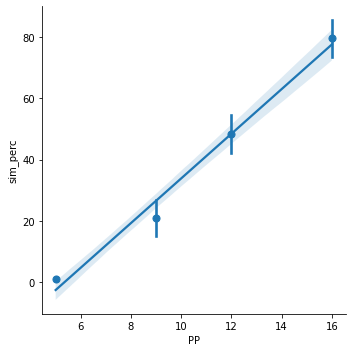

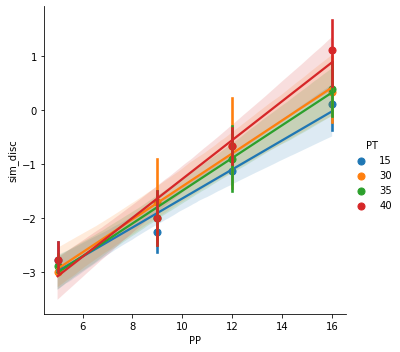

In [39]:
sns.lmplot(x="PP", y="sim_perc", data=dataset, x_estimator=np.mean)
sns.lmplot(x="PP", y="sim_disc", hue="PT", data=dataset, x_estimator=np.mean);

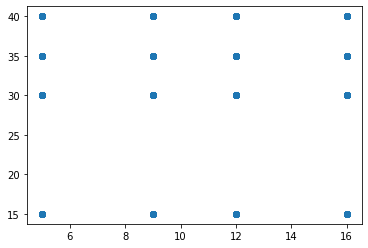

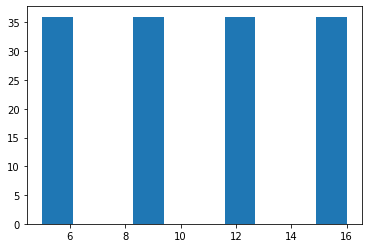

(array([43.,  0., 25.,  0., 34.,  0., 23.,  0., 11.,  8.]),
 array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 10 Patch objects>)

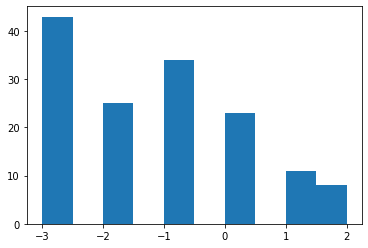

In [43]:
# Scatter plot
#h = dataset['PP']
#v = dataset['PT']
#plt.scatter(h,v)
#plt.show()

# Histogram
#plt.hist(h)
#plt.show()

# Histogram for sim index
plt.hist(dataset['sim_disc'])

### Training models with one setting

In [24]:
results = fitmodels(MODELS, *data, verbose=True)


Training LinearRegression ...
Training performance:
Root mean squared error (RMSE): 0.75
Coefficient of determination (R^2): 0.73
 
Testing performance:
Root mean squared error (RMSE): 0.85
Coefficient of determination (R^2): 0.60

Training BayesianRidge ...
Training performance:
Root mean squared error (RMSE): 0.76
Coefficient of determination (R^2): 0.73
 
Testing performance:
Root mean squared error (RMSE): 0.85
Coefficient of determination (R^2): 0.60

Training RandomForestRegressor ...

Performing hyperparamter optimization for RandomForestRegressor ...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit

Best Estimator:
 RandomForestRegressor()
Training performance:
Root mean squared error (RMSE): 0.30
Coefficient of determination (R^2): 0.96
 
Testing performance:
Root mean squared error (RMSE): 1.18
Coefficient of determination (R^2): 0.24

Training DecisionTreeRegressor ...

Performing hyperparamter optimization for DecisionTreeRegressor ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Estimator:
 DecisionTreeRegressor(criterion='friedman_mse', max_features='auto')
Training performance:
Root mean squared error (RMSE): 0.11
Coefficient of determination (R^2): 0.99
 
Testing performance:
Root mean squared error (RMSE): 1.34
Coefficient of determination (R^2): 0.01

Training SVR ...

Performing hyperparamter optimization for SVR ...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Estimator:
 SVR(C=1, degree=2)
Training performance:
Root mean squared error (RMSE): 0.67
Coefficient of determination (R^2): 0.79
 
Testing performance:
Root mean squar

### Training models with all possible settings

In [17]:
# Process some strings and column names for the output file
num_trials = len(COMPLX_SWITCH) * len(Y_SWITCH)
cols = ['Design Complexity', 'Labeling Method']
for name in MODEL_NAMES:
    cols.append('rmse_train_'+name)
    cols.append('rmse_test_'+name)
    cols.append('r2_train_'+name)
    cols.append('r2_test_'+name)
df = pd.DataFrame(columns=cols)

# Loop through possible configs
k = 0
for i,descomp in enumerate(COMPLX_SWITCH):
    for j,out in enumerate(Y_SWITCH):
        k += 1
        print("\n>>>>>>>>>>>>>>>>>>>>>>> Training trial %d out of %d >>>>>>>>>>>>\n" % (k,num_trials))
        xcols = FIXED_INPUTS
        xcols.append(descomp)
        X = dataset[xcols]
        y = dataset[out]
        sc = StandardScaler()
        x = sc.fit_transform(X)
        data = x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
        results = fitmodels(MODELS, *data, verbose=False)
        entry = {}
        entry['Design Complexity'] = COMPLX_NAMES[i]
        entry['Labeling Method'] = Y_NAMES[j]
        m = 2
        for n,col in enumerate(cols[2::4]):
            entry[cols[m]] = results[n]['performance']['rmse_train']
            entry[cols[m+1]] = results[n]['performance']['rmse_test']
            entry[cols[m+2]] = results[n]['performance']['r2_train']
            entry[cols[m+3]] = results[n]['performance']['r2_test']
            m += 4
        print("entry to be appended:")
        print(entry)
        df = df.append(entry, ignore_index=True)


print("Done.")


>>>>>>>>>>>>>>>>>>>>>>> Training trial 1 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended:
{'Design Complexity': 'Auto', 'Labeling Method': 'Discrete', 'rmse_train_LR': 0.7708493852309243, 'rmse_test_LR': 0.9442402736141322, 'r2_train_LR': 0.747933954145767, 'r2_test_LR': 0.5079875768249191, 'rmse_train_BR': 0.7709425669205431, 'rmse_test_BR': 0.9410003554606512, 'r2_train_BR': 0.7478730100492134, 'r2_test_BR': 0.5113582128545162, 'rmse_train_RF': 0.31612529688771734, 'rmse_test_RF': 1.1233169121211837, 'r2_train_RF': 0.9576070354096005, 'r2_test_RF': 0.3036691703849522, 'rmse_train_DT': 0.18650096164806276, 'rmse_test_DT': 1.174440439029407, 'r2_train_DT': 0.985245060302797, 'r2_test_DT': 0.2388451443569557, 'rmse_train_SVR': 0.7146346531178926, 'rmse_test_SVR': 1.0262542745087249, 'r2_train_SVR': 0.7833576135054718, 'r2_test_SVR': 0.41880618108150436}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 2 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestReg

D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended:
{'Design Complexity': 'Auto', 'Labeling Method': 'SSIM', 'rmse_train_LR': 0.34172720042481053, 'rmse_test_LR': 0.3984942506685158, 'r2_train_LR': 0.7150059822133867, 'r2_test_LR': 0.5145425943312951, 'rmse_train_BR': 0.34177856120508365, 'rmse_test_BR': 0.397950477091926, 'r2_train_BR': 0.7149203079381155, 'r2_test_BR': 0.5158665722826845, 'rmse_train_RF': 0.1956542723711129, 'rmse_test_RF': 0.45030608366623115, 'r2_train_RF': 0.9065766754194222, 'r2_test_RF': 0.3800985681509882, 'rmse_train_DT': 0.14756476302103086, 'rmse_test_DT': 0.5238900576781792, 'r2_train_DT': 0.9468575006282152, 'r2_test_DT': 0.16095100051560263, 'rmse_train_SVR': 0.3053630360227648, 'rmse_test_SVR': 0.4232748514073849, 'r2_train_SVR': 0.7724328469437595, 'r2_test_SVR': 0.4522883953705441}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 4 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestReg

D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended:
{'Design Complexity': 'Auto', 'Labeling Method': 'Manual', 'rmse_train_LR': 0.7569574293806293, 'rmse_test_LR': 0.8471426088197851, 'r2_train_LR': 0.7290187143343169, 'r2_test_LR': 0.6050103702034091, 'rmse_train_BR': 0.7570588558349212, 'rmse_test_BR': 0.8454916055579689, 'r2_train_BR': 0.7289460906667642, 'r2_test_BR': 0.6065484670726293, 'rmse_train_RF': 0.3173760963161309, 'rmse_test_RF': 1.218413336838929, 'r2_train_RF': 0.9523629548121637, 'r2_test_RF': 0.18292498629290288, 'rmse_train_DT': 0.19781414201873612, 'rmse_test_DT': 1.4680505487867588, 'r2_train_DT': 0.9814940637963095, 'r2_test_DT': -0.18619109947643975, 'rmse_train_SVR': 0.6350819026752245, 'rmse_test_SVR': 1.0160068294318163, 'r2_train_SVR': 0.8092538145268439, 'r2_test_SVR': 0.43184622582643384}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 5 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestR

D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended:
{'Design Complexity': 'Manual', 'Labeling Method': 'Discrete', 'rmse_train_LR': 0.7553379711824018, 'rmse_test_LR': 0.9365110490078966, 'r2_train_LR': 0.7579762851026737, 'r2_test_LR': 0.5160094969340123, 'rmse_train_BR': 0.7554951221270412, 'rmse_test_BR': 0.9323962974842276, 'r2_train_BR': 0.7578755667131357, 'r2_test_BR': 0.5202531748504653, 'rmse_train_RF': 0.2606680381001026, 'rmse_test_RF': 1.1024127145055287, 'r2_train_RF': 0.971176225301514, 'r2_test_RF': 0.32934455380577454, 'rmse_train_DT': 0.0, 'rmse_test_DT': 1.0667385033281394, 'r2_train_DT': 1.0, 'r2_test_DT': 0.3720472440944884, 'rmse_train_SVR': 0.49491342384215165, 'rmse_test_SVR': 1.0307541794953174, 'r2_train_SVR': 0.8960956439525145, 'r2_test_SVR': 0.41369818624797816}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 6 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...

Training Decis

D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 1315, in fit
    super().fit(
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 178, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poi

entry to be appended:
{'Design Complexity': 'Manual', 'Labeling Method': 'SSIM', 'rmse_train_LR': 0.3414846674746101, 'rmse_test_LR': 0.3991946527078845, 'r2_train_LR': 0.7154103744392515, 'r2_test_LR': 0.5128345939497235, 'rmse_train_BR': 0.3415790642609122, 'rmse_test_BR': 0.3985141357172712, 'r2_train_BR': 0.7152530141728055, 'r2_test_BR': 0.5144941440210716, 'rmse_train_RF': 0.16766505513294983, 'rmse_test_RF': 0.39488161485927953, 'r2_train_RF': 0.931394053739475, 'r2_test_RF': 0.523304734136594, 'rmse_train_DT': 0.06686576926926231, 'rmse_test_DT': 0.3304745085781298, 'r2_train_DT': 0.9890885030043969, 'r2_test_DT': 0.6661257375152927, 'rmse_train_SVR': 0.2862447083312316, 'rmse_test_SVR': 0.35571831936357146, 'r2_train_SVR': 0.8000361083516453, 'r2_test_SVR': 0.6131705998284628}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 8 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 1315, in fit
    super().fit(
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 178, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poi

entry to be appended:
{'Design Complexity': 'Manual', 'Labeling Method': 'Manual', 'rmse_train_LR': 0.754959256047491, 'rmse_test_LR': 0.8538211102852531, 'r2_train_LR': 0.7304474681587467, 'r2_test_LR': 0.5987579707342197, 'rmse_train_BR': 0.755142197277156, 'rmse_test_BR': 0.8517576087011627, 'r2_train_BR': 0.7303168167470371, 'r2_test_BR': 0.6006950581364845, 'rmse_train_RF': 0.4674875027392618, 'rmse_test_RF': 1.0772718575978926, 'r2_train_RF': 0.8966438322486053, 'r2_test_RF': 0.361261240183246, 'rmse_train_DT': 0.11420804814403214, 'rmse_test_DT': 1.3031791365997867, 'r2_train_DT': 0.9938313545987698, 'r2_test_DT': 0.06528141361256545, 'rmse_train_SVR': 0.669921982133348, 'rmse_test_SVR': 0.9098217915772843, 'r2_train_SVR': 0.7877513951196577, 'r2_test_SVR': 0.5443983263529423}
Done.


In [18]:
# Save results in a file
df.to_csv('ensemble_results.csv', index=False, float_format='%.2f')
print("Done.")

Done.


In [28]:
# Describing what we have so far
from IPython.display import display
display(df)

,Design Complexity,Labeling Method,rmse_train_LR,rmse_test_LR,r2_train_LR,r2_test_LR,rmse_train_BR,rmse_test_BR,r2_train_BR,r2_test_BR,...,r2_train_RF,r2_test_RF,rmse_train_DT,rmse_test_DT,r2_train_DT,r2_test_DT,rmse_train_SVR,rmse_test_SVR,r2_train_SVR,r2_test_SVR
0,Auto,Discrete,0.770849,0.944240,0.747934,0.507988,0.770943,0.941000,0.747873,0.511358,...,0.957607,0.303669,0.186501,1.174440,0.985245,0.238845,0.714635,1.026254,0.783358,0.418806
1,Auto,Percentage,15.315845,21.079027,0.801732,0.531010,15.317207,21.028396,0.801696,0.533260,...,0.961985,0.299366,4.661549,32.630950,0.981633,-0.123886,12.894123,25.905777,0.859474,0.291637
2,Auto,SSIM,0.341727,0.398494,0.715006,0.514543,0.341779,0.397950,0.714920,0.515867,...,0.906577,0.380099,0.147565,0.523890,0.946858,0.160951,0.305363,0.423275,0.772433,0.452288
3,Auto,Manual,0.756957,0.847143,0.729019,0.605010,0.757059,0.845492,0.728946,0.606548,...,0.952363,0.182925,0.197814,1.468051,0.981494,-0.186191,0.635082,1.016007,0.809254,0.431846
4,Manual,Discrete,0.755338,0.936511,0.757976,0.516009,0.755495,0.932396,0.757876,0.520253,...,0.971176,0.329345,0.000000,1.066739,1.000000,0.372047,0.494913,1.030754,0.896096,0.413698
5,Manual,Percentage,15.113445,20.594765,0.806937,0.552311,15.115812,20.531253,0.806877,0.555068,...,0.955063,0.435577,0.278564,23.154640,0.999934,0.434101,12.028105,18.959790,0.877717,0.620572
6,Manual,SSIM,0.341485,0.399195,0.715410,0.512835,0.341579,0.398514,0.715253,0.514494,...,0.931394,0.523305,0.066866,0.330475,0.989089,0.666126,0.286245,0.355718,0.800036,0.613171
7,Manual,Manual,0.754959,0.853821,0.730447,0.598758,0.755142,0.851758,0.730317,0.600695,...,0.896644,0.361261,0.114208,1.303179,0.993831,0.065281,0.669922,0.909822,0.787751,0.544398


### Training with designs 1 to 7

In [31]:
# Smaller dataset
dataset_small = dataset.loc[dataset['design'] < 8]

# Loop through possible configs
k = 0
for i,descomp in enumerate(COMPLX_SWITCH):
    for j,out in enumerate(Y_SWITCH):
        k += 1
        print("\n>>>>>>>>>>>>>>>>>>>>>>> Training trial %d out of %d >>>>>>>>>>>>\n" % (k,num_trials))
        xcols = FIXED_INPUTS
        xcols.append(descomp)
        X = dataset_small[xcols]
        y = dataset_small[out]
        sc = StandardScaler()
        x = sc.fit_transform(X)
        data = x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
        results = fitmodels(MODELS, *data, verbose=False)
        entry = {}
        entry['Design Complexity'] = COMPLX_NAMES[i]
        entry['Labeling Method'] = Y_NAMES[j]
        m = 2
        for n,col in enumerate(cols[2::4]):
            entry[cols[m]] = results[n]['performance']['rmse_train']
            entry[cols[m+1]] = results[n]['performance']['rmse_test']
            entry[cols[m+2]] = results[n]['performance']['r2_train']
            entry[cols[m+3]] = results[n]['performance']['r2_test']
            m += 4
        print("entry to be appended:")
        print(entry)
        df = df.append(entry, ignore_index=True)


# Save results in a file
df.to_csv('ensemble_results_7_designs.csv', index=False, float_format='%.2f')
print("Done.")


>>>>>>>>>>>>>>>>>>>>>>> Training trial 1 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended:
{'Design Complexity': 'Auto', 'Labeling Method': 'Discrete', 'rmse_train_LR': 0.7391748877269572, 'rmse_test_LR': 0.9965647132521317, 'r2_train_LR': 0.7752688682359419, 'r2_test_LR': 0.516232311737632, 'rmse_train_BR': 0.7394240446718109, 'rmse_test_BR': 0.9948806391042758, 'r2_train_BR': 0.7751173404714251, 'r2_test_BR': 0.5178659483166319, 'rmse_train_RF': 0.49855775137959113, 'rmse_test_RF': 0.9573332525937555, 'r2_train_RF': 0.8977649587184546, 'r2_test_RF': 0.553571270718232, 'rmse_train_DT': 0.07495316889958614, 'rmse_test_DT': 1.0834726777719228, 'r2_train_DT': 0.997689271990861, 'r2_test_DT': 0.42817679558011046, 'rmse_train_SVR': 0.5876119692445779, 'rmse_test_SVR': 1.0508875588972804, 'r2_train_SVR': 0.8579798072016633, 'r2_test_SVR': 0.4620544144526243}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 2 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestReg

D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended:
{'Design Complexity': 'Auto', 'Labeling Method': 'SSIM', 'rmse_train_LR': 0.320312930976561, 'rmse_test_LR': 0.38262069379205144, 'r2_train_LR': 0.7137745479045016, 'r2_test_LR': 0.6235611606244926, 'rmse_train_BR': 0.3204594550639554, 'rmse_test_BR': 0.3829809946810065, 'r2_train_BR': 0.7135126258190638, 'r2_test_BR': 0.6228518675291019, 'rmse_train_RF': 0.14365181940529925, 'rmse_test_RF': 0.37126406042345117, 'r2_train_RF': 0.942431943363378, 'r2_test_RF': 0.6455758256778115, 'rmse_train_DT': 0.0816774342252725, 'rmse_test_DT': 0.3897520518925953, 'r2_train_DT': 0.9813892669219988, 'r2_test_DT': 0.6093981134492543, 'rmse_train_SVR': 0.20778912733589947, 'rmse_test_SVR': 0.3613544133855198, 'r2_train_SVR': 0.8795505155398446, 'r2_test_SVR': 0.6642436440922546}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 4 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegre

D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended:
{'Design Complexity': 'Auto', 'Labeling Method': 'Manual', 'rmse_train_LR': 0.7589423246169555, 'rmse_test_LR': 0.9314251796749792, 'r2_train_LR': 0.7395270533201415, 'r2_test_LR': 0.4724879703897378, 'rmse_train_BR': 0.7592509300415897, 'rmse_test_BR': 0.92812506899873, 'r2_train_BR': 0.7393151802840033, 'r2_test_BR': 0.47621937928809, 'rmse_train_RF': 0.5217184763254277, 'rmse_test_RF': 0.9290106939993841, 'r2_train_RF': 0.8769114909225851, 'r2_test_RF': 0.47521931034482756, 'rmse_train_DT': 0.12982269672237465, 'rmse_test_DT': 1.179535649239177, 'r2_train_DT': 0.9923783968942681, 'r2_test_DT': 0.15402298850574703, 'rmse_train_SVR': 0.7344506301863291, 'rmse_test_SVR': 0.8661300847441344, 'r2_train_SVR': 0.7560671486114148, 'r2_test_SVR': 0.5438552640957376}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 5 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegress

D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended:
{'Design Complexity': 'Manual', 'Labeling Method': 'Discrete', 'rmse_train_LR': 0.7391748877269572, 'rmse_test_LR': 0.9965647132521321, 'r2_train_LR': 0.7752688682359419, 'r2_test_LR': 0.5162323117376316, 'rmse_train_BR': 0.7394253943714446, 'rmse_test_BR': 0.9949123086201718, 'r2_train_BR': 0.775116519496445, 'r2_test_BR': 0.5178352527850518, 'rmse_train_RF': 0.5194170781978539, 'rmse_test_RF': 0.9581776180991115, 'r2_train_RF': 0.8890311000623118, 'r2_test_RF': 0.5527834254143646, 'rmse_train_DT': 0.07495316889958614, 'rmse_test_DT': 1.4890907643081486, 'r2_train_DT': 0.997689271990861, 'r2_test_DT': -0.08011049723756924, 'rmse_train_SVR': 0.49811809881645064, 'rmse_test_SVR': 0.9994400644699296, 'r2_train_SVR': 0.8979451909149958, 'r2_test_SVR': 0.5134366905475224}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 6 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomFores

D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended:
{'Design Complexity': 'Manual', 'Labeling Method': 'SSIM', 'rmse_train_LR': 0.32031293097656094, 'rmse_test_LR': 0.3826206937920513, 'r2_train_LR': 0.7137745479045017, 'r2_test_LR': 0.6235611606244928, 'rmse_train_BR': 0.3204597179312037, 'rmse_test_BR': 0.3829924230938302, 'r2_train_BR': 0.7135121558177739, 'r2_test_BR': 0.6228293584807514, 'rmse_train_RF': 0.1424877777857729, 'rmse_test_RF': 0.36465608091045404, 'r2_train_RF': 0.9433611360375739, 'r2_test_RF': 0.6580800539425038, 'rmse_train_DT': 0.0816774342252725, 'rmse_test_DT': 0.4233423185427324, 'r2_train_DT': 0.9813892669219988, 'r2_test_DT': 0.5391698512976004, 'rmse_train_SVR': 0.2129686381538907, 'rmse_test_SVR': 0.36420490624224394, 'r2_train_SVR': 0.873470842950161, 'r2_test_SVR': 0.6589256188069765}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 8 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestReg

D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 1315, in fit
    super().fit(
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 178, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poi

entry to be appended:
{'Design Complexity': 'Manual', 'Labeling Method': 'Manual', 'rmse_train_LR': 0.7589423246169554, 'rmse_test_LR': 0.931425179674979, 'r2_train_LR': 0.7395270533201416, 'r2_test_LR': 0.472487970389738, 'rmse_train_BR': 0.7592513237230247, 'rmse_test_BR': 0.9281231335709859, 'r2_train_BR': 0.7393149099470265, 'r2_test_BR': 0.47622156377490554, 'rmse_train_RF': 0.5779669424083473, 'rmse_test_RF': 0.9108375266753123, 'r2_train_RF': 0.8489394453642385, 'r2_test_RF': 0.4955498563218389, 'rmse_train_DT': 0.12982269672237465, 'rmse_test_DT': 0.9835605239881408, 'r2_train_DT': 0.9923783968942681, 'r2_test_DT': 0.4117816091954022, 'rmse_train_SVR': 0.6296951903301085, 'rmse_test_SVR': 0.8792036614050925, 'r2_train_SVR': 0.8206894556283566, 'r2_test_SVR': 0.5299810202497979}
Done.


### Training with designs 2 to 9

In [37]:
# Smaller dataset
dataset_small_3to9 = dataset.loc[3 <= dataset['design']]

In [38]:
# Loop through possible configs
k = 0
for i,descomp in enumerate(COMPLX_SWITCH):
    for j,out in enumerate(Y_SWITCH):
        k += 1
        print("\n>>>>>>>>>>>>>>>>>>>>>>> Training trial %d out of %d >>>>>>>>>>>>\n" % (k,num_trials))
        xcols = FIXED_INPUTS
        xcols.append(descomp)
        X = dataset_small_3to9[xcols]
        y = dataset_small_3to9[out]
        sc = StandardScaler()
        x = sc.fit_transform(X)
        data = x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
        results = fitmodels(MODELS, *data, verbose=False)
        entry = {}
        entry['Design Complexity'] = COMPLX_NAMES[i]
        entry['Labeling Method'] = Y_NAMES[j]
        m = 2
        for n,col in enumerate(cols[2::4]):
            entry[cols[m]] = results[n]['performance']['rmse_train']
            entry[cols[m+1]] = results[n]['performance']['rmse_test']
            entry[cols[m+2]] = results[n]['performance']['r2_train']
            entry[cols[m+3]] = results[n]['performance']['r2_test']
            m += 4
        print("entry to be appended:")
        print(entry)
        df = df.append(entry, ignore_index=True)


# Save results in a file
df.to_csv('ensemble_results_7_designs_3to9.csv', index=False, float_format='%.2f')
print("Done.")


>>>>>>>>>>>>>>>>>>>>>>> Training trial 1 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 1315, in fit
    super().fit(
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 178, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poi

entry to be appended:
{'Design Complexity': 'Auto', 'Labeling Method': 'Discrete', 'rmse_train_LR': 0.8785839506305858, 'rmse_test_LR': 0.7842072784132419, 'r2_train_LR': 0.6938565393781777, 'r2_test_LR': 0.6877879286294387, 'rmse_train_BR': 0.8790285365429485, 'rmse_test_BR': 0.7828144844375287, 'r2_train_BR': 0.693546628170528, 'r2_test_BR': 0.6888959543983613, 'rmse_train_RF': 0.5424957929728658, 'rmse_test_RF': 0.7652578423102838, 'r2_train_RF': 0.8832784072701783, 'r2_test_RF': 0.7026940978886755, 'rmse_train_DT': 0.0, 'rmse_test_DT': 1.2335879094879225, 'r2_train_DT': 1.0, 'r2_test_DT': 0.22744721689059488, 'rmse_train_SVR': 0.7280483153849975, 'rmse_test_SVR': 0.6144638094332118, 'r2_train_SVR': 0.789777663595724, 'r2_test_SVR': 0.8083183359197896}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 2 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...

Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended

D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 1315, in fit
    super().fit(
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 178, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poi

entry to be appended:
{'Design Complexity': 'Auto', 'Labeling Method': 'SSIM', 'rmse_train_LR': 0.36030776525627, 'rmse_test_LR': 0.404601541298736, 'r2_train_LR': 0.672484466913405, 'r2_test_LR': 0.6281196664675162, 'rmse_train_BR': 0.36053153313726083, 'rmse_test_BR': 0.4087305462327096, 'r2_train_BR': 0.6720775358319284, 'r2_test_BR': 0.6204907746857504, 'rmse_train_RF': 0.18039068741307018, 'rmse_test_RF': 0.37132804828750765, 'r2_train_RF': 0.91790572248558, 'r2_test_RF': 0.6867697796840913, 'rmse_train_DT': 0.0, 'rmse_test_DT': 0.5390319093132151, 'r2_train_DT': 1.0, 'r2_test_DT': 0.33994960355350357, 'rmse_train_SVR': 0.2845937219124331, 'rmse_test_SVR': 0.33106644580255384, 'r2_train_SVR': 0.7956685161471949, 'r2_test_SVR': 0.7510119643246711}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 4 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended:
{'Design Complexity': 'Auto', 'Labeling Method': 'Manual', 'rmse_train_LR': 0.776328906019685, 'rmse_test_LR': 0.7737462633311902, 'r2_train_LR': 0.6960473498332898, 'r2_test_LR': 0.6989510882794294, 'rmse_train_BR': 0.7767147063258107, 'rmse_test_BR': 0.7787894426987167, 'r2_train_BR': 0.6957451733658779, 'r2_test_BR': 0.6950139021718638, 'rmse_train_RF': 0.5590772895855609, 'rmse_test_RF': 0.8959789399698886, 'r2_train_RF': 0.8423630141347256, 'r2_test_RF': 0.5963215779467679, 'rmse_train_DT': 0.0, 'rmse_test_DT': 1.1420804814403216, 'r2_train_DT': 1.0, 'r2_test_DT': 0.3441064638783268, 'rmse_train_SVR': 0.6254539590907218, 'rmse_test_SVR': 0.7209785603866847, 'r2_train_SVR': 0.8027099821853032, 'r2_test_SVR': 0.7386126095815506}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 5 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 1315, in fit
    super().fit(
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 178, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poi

entry to be appended:
{'Design Complexity': 'Manual', 'Labeling Method': 'Discrete', 'rmse_train_LR': 0.8785839506305858, 'rmse_test_LR': 0.7842072784132422, 'r2_train_LR': 0.6938565393781777, 'r2_test_LR': 0.6877879286294384, 'rmse_train_BR': 0.8790290877623936, 'rmse_test_BR': 0.7828131720394624, 'r2_train_BR': 0.6935462438300807, 'r2_test_BR': 0.6888969975369688, 'rmse_train_RF': 0.5284716675194485, 'rmse_test_RF': 0.7128807144561271, 'r2_train_RF': 0.8892351729921891, 'r2_test_RF': 0.7419988243761996, 'rmse_train_DT': 0.0, 'rmse_test_DT': 1.103354568734741, 'r2_train_DT': 1.0, 'r2_test_DT': 0.38195777351247584, 'rmse_train_SVR': 0.7323773836922852, 'rmse_test_SVR': 0.6150290248045421, 'r2_train_SVR': 0.7872702131377789, 'r2_test_SVR': 0.8079655364537218}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 6 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...

Training DecisionTreeRegressor ...

Training SVR ...
entry to be appen

D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended:
{'Design Complexity': 'Manual', 'Labeling Method': 'SSIM', 'rmse_train_LR': 0.36030776525627, 'rmse_test_LR': 0.4046015412987358, 'r2_train_LR': 0.672484466913405, 'r2_test_LR': 0.6281196664675165, 'rmse_train_BR': 0.3605320770324347, 'rmse_test_BR': 0.4087454894998612, 'r2_train_BR': 0.6720765464284293, 'r2_test_BR': 0.6204630243183702, 'rmse_train_RF': 0.14219068918415964, 'rmse_test_RF': 0.38959214290866573, 'r2_train_RF': 0.9489933293908894, 'r2_test_RF': 0.6551989930666866, 'rmse_train_DT': 0.0, 'rmse_test_DT': 0.572628659961671, 'r2_train_DT': 1.0, 'r2_test_DT': 0.2551062895873595, 'rmse_train_SVR': 0.28708681908042005, 'rmse_test_SVR': 0.33149604500807195, 'r2_train_SVR': 0.7920728672870608, 'r2_test_SVR': 0.7503653602136705}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 8 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 1315, in fit
    super().fit(
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 178, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poi

entry to be appended:
{'Design Complexity': 'Manual', 'Labeling Method': 'Manual', 'rmse_train_LR': 0.776328906019685, 'rmse_test_LR': 0.7737462633311911, 'r2_train_LR': 0.6960473498332898, 'r2_test_LR': 0.6989510882794286, 'rmse_train_BR': 0.7767150620080178, 'rmse_test_BR': 0.7787950965443541, 'r2_train_BR': 0.6957448947100159, 'r2_test_BR': 0.6950094738874436, 'rmse_train_RF': 0.5443726417020862, 'rmse_test_RF': 0.8628290172702111, 'r2_train_RF': 0.8505461861708901, 'r2_test_RF': 0.6256400190114066, 'rmse_train_DT': 0.0, 'rmse_test_DT': 0.8597269536210951, 'r2_train_DT': 1.0, 'r2_test_DT': 0.6283269961977185, 'rmse_train_SVR': 0.6304244807035138, 'rmse_test_SVR': 0.7223846949283508, 'r2_train_SVR': 0.7995617700293769, 'r2_test_SVR': 0.7375920403898305}
Done.


In [46]:
# Getting rid of "5" psi
dataset_new = dataset[dataset['PP'] != 5]

# Loop through possible configs
k = 0
for i,descomp in enumerate(COMPLX_SWITCH):
    for j,out in enumerate(Y_SWITCH):
        k += 1
        print("\n>>>>>>>>>>>>>>>>>>>>>>> Training trial %d out of %d >>>>>>>>>>>>\n" % (k,num_trials))
        xcols = FIXED_INPUTS
        xcols.append(descomp)
        X = dataset_new[xcols]
        y = dataset_new[out]
        sc = StandardScaler()
        x = sc.fit_transform(X)
        data = x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
        results = fitmodels(MODELS, *data, verbose=False)
        entry = {}
        entry['Design Complexity'] = COMPLX_NAMES[i]
        entry['Labeling Method'] = Y_NAMES[j]
        m = 2
        for n,col in enumerate(cols[2::4]):
            entry[cols[m]] = results[n]['performance']['rmse_train']
            entry[cols[m+1]] = results[n]['performance']['rmse_test']
            entry[cols[m+2]] = results[n]['performance']['r2_train']
            entry[cols[m+3]] = results[n]['performance']['r2_test']
            m += 4
        print("entry to be appended:")
        print(entry)
        df = df.append(entry, ignore_index=True)


# Save results in a file
df.to_csv('ensemble_results_without_5psi.csv', index=False, float_format='%.2f')
print("Done.")


>>>>>>>>>>>>>>>>>>>>>>> Training trial 1 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended:
{'Design Complexity': 'Auto', 'Labeling Method': 'Discrete', 'rmse_train_LR': 0.8875551509838523, 'rmse_test_LR': 0.7816261436628292, 'r2_train_LR': 0.5736073138102447, 'r2_test_LR': 0.6517141538594848, 'rmse_train_BR': 0.888429605445157, 'rmse_test_BR': 0.7922237471234074, 'r2_train_BR': 0.5727667020127846, 'r2_test_BR': 0.6422057275559172, 'rmse_train_RF': 0.369506610153326, 'rmse_test_RF': 0.8553835013275825, 'r2_train_RF': 0.9260967609727732, 'r2_test_RF': 0.5828815403742966, 'rmse_train_DT': 0.07624928516630233, 'rmse_test_DT': 1.5521246435421703, 'r2_train_DT': 0.9968530444964872, 'r2_test_DT': -0.3733804475853948, 'rmse_train_SVR': 0.9285665877198178, 'rmse_test_SVR': 0.8820880216671769, 'r2_train_SVR': 0.5332920978990108, 'r2_test_SVR': 0.5564306589671877}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 2 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestReg

D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 1315, in fit
    super().fit(
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 178, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poi

entry to be appended:
{'Design Complexity': 'Auto', 'Labeling Method': 'SSIM', 'rmse_train_LR': 0.3920964661991761, 'rmse_test_LR': 0.40319409735910494, 'r2_train_LR': 0.5329548723759271, 'r2_test_LR': 0.5334640012027512, 'rmse_train_BR': 0.3925887246860557, 'rmse_test_BR': 0.4024163275386044, 'r2_train_BR': 0.53178143029586, 'r2_test_BR': 0.5352621805037807, 'rmse_train_RF': 0.22689773628161156, 'rmse_test_RF': 0.38309428208987206, 'r2_train_RF': 0.8436012364268741, 'r2_test_RF': 0.5788195840774795, 'rmse_train_DT': 0.03301463563480538, 'rmse_test_DT': 0.6153604915093916, 'r2_train_DT': 0.9966887954784753, 'r2_test_DT': -0.0867159670258042, 'rmse_train_SVR': 0.27308331373961126, 'rmse_test_SVR': 0.3813807171233692, 'r2_train_SVR': 0.7734503906354718, 'r2_test_SVR': 0.5825790027220203}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 4 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 1315, in fit
    super().fit(
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 178, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poi

entry to be appended:
{'Design Complexity': 'Auto', 'Labeling Method': 'Manual', 'rmse_train_LR': 0.7961602925144505, 'rmse_test_LR': 0.9488200661644344, 'r2_train_LR': 0.47092749358514396, 'r2_test_LR': 0.2749989905310475, 'rmse_train_BR': 0.7973349708743728, 'rmse_test_BR': 0.9510264509395789, 'r2_train_BR': 0.4693651235139109, 'r2_test_BR': 0.2716232375587717, 'rmse_train_RF': 0.7226889790671478, 'rmse_test_RF': 0.9492287539222184, 'r2_train_RF': 0.5640697268931272, 'r2_test_RF': 0.2743742928452575, 'rmse_train_DT': 0.10783277320343841, 'rmse_test_DT': 1.1281521496355325, 'r2_train_DT': 0.9902945491479517, 'r2_test_DT': -0.02495840266223004, 'rmse_train_SVR': 0.685156678564153, 'rmse_test_SVR': 0.8895315598974226, 'r2_train_SVR': 0.6081733630241355, 'r2_test_SVR': 0.36277381748766324}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 5 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 1315, in fit
    super().fit(
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 178, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poi

entry to be appended:
{'Design Complexity': 'Manual', 'Labeling Method': 'Discrete', 'rmse_train_LR': 0.887555150983852, 'rmse_test_LR': 0.7816261436628297, 'r2_train_LR': 0.5736073138102449, 'r2_test_LR': 0.6517141538594845, 'rmse_train_BR': 0.8884320445817327, 'rmse_test_BR': 0.7922517190555607, 'r2_train_BR': 0.5727643561166379, 'r2_test_BR': 0.6421804610227306, 'rmse_train_RF': 0.7604382151560819, 'rmse_test_RF': 0.8458333706523353, 'r2_train_RF': 0.6869981411007025, 'r2_test_RF': 0.5921435806831566, 'rmse_train_DT': 0.07624928516630233, 'rmse_test_DT': 1.381698559415515, 'r2_train_DT': 0.9968530444964872, 'r2_test_DT': -0.08833922261484117, 'rmse_train_SVR': 0.9486333501542001, 'rmse_test_SVR': 0.8987214332266968, 'r2_train_SVR': 0.5129025831783312, 'r2_test_SVR': 0.5395442828764814}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 6 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...

Training DecisionTreeRegressor ...

Tra

D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 1315, in fit
    super().fit(
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\tree\_classes.py", line 178, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poi

entry to be appended:
{'Design Complexity': 'Manual', 'Labeling Method': 'SSIM', 'rmse_train_LR': 0.39209646619917604, 'rmse_test_LR': 0.4031940973591049, 'r2_train_LR': 0.5329548723759272, 'r2_test_LR': 0.5334640012027514, 'rmse_train_BR': 0.3925897000132653, 'rmse_test_BR': 0.4024147159634834, 'r2_train_BR': 0.5317791038567667, 'r2_test_BR': 0.5352659028100429, 'rmse_train_RF': 0.23197440353035043, 'rmse_test_RF': 0.3778895745544153, 'r2_train_RF': 0.8365243312221871, 'r2_test_RF': 0.5901861324271687, 'rmse_train_DT': 0.03301463563480538, 'rmse_test_DT': 0.45636434281356614, 'r2_train_DT': 0.9966887954784753, 'r2_test_DT': 0.402304153546029, 'rmse_train_SVR': 0.27776500191340764, 'rmse_test_SVR': 0.3861822211080723, 'r2_train_SVR': 0.7656159589301688, 'r2_test_SVR': 0.5720023530500571}

>>>>>>>>>>>>>>>>>>>>>>> Training trial 8 out of 8 >>>>>>>>>>>>


Training LinearRegression ...

Training BayesianRidge ...

Training RandomForestRegressor ...


D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\envs\myEnv001\lib\site-packages\sklearn\ensemble\_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\Anaconda3\envs\myEnv001\lib\sit


Training DecisionTreeRegressor ...

Training SVR ...
entry to be appended:
{'Design Complexity': 'Manual', 'Labeling Method': 'Manual', 'rmse_train_LR': 0.7961602925144505, 'rmse_test_LR': 0.9488200661644343, 'r2_train_LR': 0.47092749358514396, 'r2_test_LR': 0.2749989905310476, 'rmse_train_BR': 0.7973359455578588, 'rmse_test_BR': 0.9510320207207952, 'r2_train_BR': 0.46936382618873074, 'r2_test_BR': 0.2716147059115487, 'rmse_train_RF': 0.7032249218405691, 'rmse_test_RF': 0.9741359808008885, 'r2_train_RF': 0.5872351822593387, 'r2_test_RF': 0.23579467554076528, 'rmse_train_DT': 0.10783277320343841, 'rmse_test_DT': 1.5954480704349312, 'r2_train_DT': 0.9902945491479517, 'r2_test_DT': -1.04991680532446, 'rmse_train_SVR': 0.6897797864408859, 'rmse_test_SVR': 0.8833797168424725, 'r2_train_SVR': 0.6028678079929034, 'r2_test_SVR': 0.3715572271575963}
Done.
